<a href="https://colab.research.google.com/github/pramod1997/Path-To-Data-Science/blob/master/boston_housing_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# link to data set - > https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: sample_submission.csv   
  inflating: data_description.txt    
  inflating: test.csv                
  inflating: train.csv               


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from time import time
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
#train.info()

In [0]:
#Threshold dropping of features, 
t = 0.8
train = train.dropna(thresh = t * len(train),axis = 1)
#train.info()

In [0]:
#train.info()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


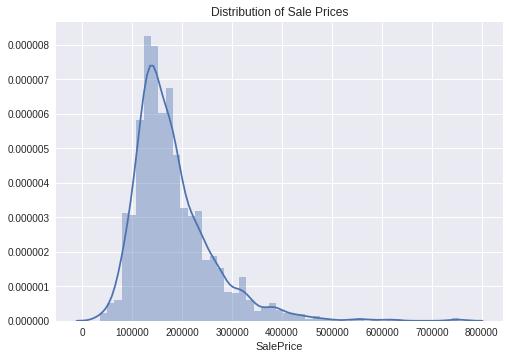

In [7]:
Y=train.iloc[:,-1]
del train['SalePrice']
del train['Id']
sns.distplot(Y)
plt.title('Distribution of Sale Prices')
plt.show()

In [0]:
train_numeric=train.select_dtypes(include=['int64','float64'])
#Use this for submission
cols_num=train_numeric.columns
#train_numeric.info()

In [0]:
train_numeric=train_numeric.fillna(train_numeric.median())
#train_numeric.info()

In [10]:
#Extracts the features with the Ex-Gd-...-NA
train_object=train.select_dtypes(include=['object'])
cols=train_object.columns
print(cols)
qual=[]
for feat in cols:
    if train_object[feat].str.contains('Ex').any():
        qual.append(feat)
        pass
    pass
print(qual)
train_qual=train_object[qual]
qual_letter=['Ex','Gd','TA','Fa','Po','NA']
qual_map={qual_letter[i]:i+1 for i in range(len(qual_letter))}
train_qual=train_qual.replace(qual_map)
train_qual=train_qual.fillna(train_qual.median())
train_qual.info()

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
['ExterQual', 'ExterCond', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
ExterQual      1460 non-null int64
ExterCond      1460 non-null int64
BsmtQual       1460 non-null float64
HeatingQC      1460 non-null int64
KitchenQual    1460 non-null int64
GarageQual     1460 no

In [0]:
X=pd.concat([train_numeric,train_qual],1)
#X.info()

In [0]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.1,random_state = 1)

In [0]:
#A few useful functions
def RMSE_CV(model,X,Y):
  scoring = 'neg_mean_squared_error'
  rmse_score = np.sqrt(-cross_val_score(model,X,Y,cv = 5,scoring=scoring))
  
  return rmse_score

def Kaggle_score(predY,testY):
  assert(len(predY)==len(testY))
  n = len(predY)
  predY = np.log(predY)
  testY = np.log(testY)
  t = np.sum((predY-testY)**2)
#  print(t)
  score = np.sqrt(t/n)
  return score
  
def report(results, n_top=2):
  for i in range(1, n_top + 1):
    candidates = np.flatnonzero(results['rank_test_score'] == i)
    for candidate in candidates:
      print("Model with rank: {0}".format(i))
      print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
            results['mean_test_score'][candidate],
            results['std_test_score'][candidate]))
      print("Parameters: {0}".format(results['params'][candidate]))
      print("")
            
  pass

Random forest, XGBoost regression testing

In [15]:
#Random forest regression, commented out
regress = RandomForestRegressor(n_estimators=100)
regress.fit(trainX,trainY)

param_dist = {
              'max_depth':[i for i in range(10,50,4)]+[None],
              "max_features": ['sqrt','log2']
              }
#Parameters: {'max_depth': 22, 'max_features': 'sqrt'}
regress_grid = GridSearchCV(regress, param_grid=param_dist,cv=5,scoring = 'neg_mean_squared_error',verbose=1)
print('Starting GridSearchCV')
start = time()
regress_grid.fit(X,Y)
print("GridSearchCV took %.2f seconds." % (time() - start))
report(regress_grid.cv_results_)

regress.set_params(**regress_grid.best_params_)
regress.fit(trainX,trainY)

Starting GridSearchCV
Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   32.5s finished


GridSearchCV took 32.81 seconds.
Model with rank: 1
Mean validation score: -849454720.535 (std: 228893314.584)
Parameters: {'max_depth': None, 'max_features': 'sqrt'}

Model with rank: 2
Mean validation score: -869230051.336 (std: 257505643.527)
Parameters: {'max_depth': 38, 'max_features': 'log2'}



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
predY=regress.predict(testX)
score = Kaggle_score(predY,testY)
print('Expected Kaggle score(Lower is better): ', score)


Expected Kaggle score(Lower is better):  0.14940049835995758


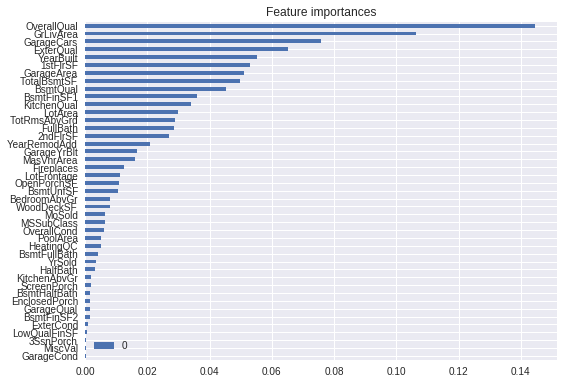

In [17]:
feats=pd.DataFrame(regress.feature_importances_,index=trainX.columns)
sort_feats=feats.sort_values(0,ascending=True)
sort_feats.plot(kind='barh',title='Feature importances')
plt.tight_layout()
plt.show()

In [18]:
print(trainX.columns)
print(test.columns)
#Fill NA values with train values NOT Sub or test
#Extract numeric
sub_numeric=test[cols_num]
sub_numeric=sub_numeric.fillna(train_numeric.median())
#Extract quality
sub_qual=test[qual]
sub_qual=sub_qual.replace(qual_map)
sub_qual=sub_qual.fillna(train_qual.median())

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual', 'HeatingQC',
       'KitchenQual', 'GarageQual', 'GarageCond'],
      dtype='object')
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 

In [19]:
subX=pd.concat([sub_numeric,sub_qual],1)
subX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 43 columns):
MSSubClass       1459 non-null int64
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
MasVnrArea       1459 non-null float64
BsmtFinSF1       1459 non-null float64
BsmtFinSF2       1459 non-null float64
BsmtUnfSF        1459 non-null float64
TotalBsmtSF      1459 non-null float64
1stFlrSF         1459 non-null int64
2ndFlrSF         1459 non-null int64
LowQualFinSF     1459 non-null int64
GrLivArea        1459 non-null int64
BsmtFullBath     1459 non-null float64
BsmtHalfBath     1459 non-null float64
FullBath         1459 non-null int64
HalfBath         1459 non-null int64
BedroomAbvGr     1459 non-null int64
KitchenAbvGr     1459 non-null int64
TotRmsAbvGrd     1459 non-null int64
Fireplaces       1459 non-

In [21]:
subY = regress.predict(subX)
subY[subY<=0]= 1
#Exporting to CSV,DONT DELETE
print('Exporting to CSV')
EXP = pd.DataFrame(subY,index = [i for i in range(1461,2919+1)],columns=['SalePrice'])
EXP.index.name = 'Id'
filename = 'Boston_RFRAllD.csv'
EXP.to_csv(filename)
print('Finished, fname: ',filename )

Exporting to CSV
Finished, fname:  Boston_RFRAllD.csv
